In [5]:
import torch
import torch.nn as nn

id_op = ['none','nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']

node_ops = [[]]*10
node_ops[0] = ['none','nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
node_ops[1] = ['none']
node_ops[2] = ['nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
node_ops[3] = ['nor_conv_1x1','nor_conv_3x3']
node_ops[4] = ['skip_connect','avg_pool_3x3']
node_ops[5] = ['nor_conv_1x1']
node_ops[6] = ['nor_conv_3x3']
node_ops[7] = ['skip_connect']
node_ops[8] = ['avg_pool_3x3']

L = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

'''
References: NATS-Bench source code (on topology search space (tss)): 
https://github.com/D-X-Y/AutoDL-Projects/tree/f46486e21b71ae6459a700be720d7648b5429569/xautodl

The following classes are modified compared to original version: MixedOp, Cell

Arch (seems to) play the role of Gentotypes in the original implementation
Cell (seems to) play the role of InferCell in the original implementation
'''

OPS = {
    "none": lambda C_in, C_out, stride, affine, track_running_stats: Zero(
        C_in, C_out, stride
    ),
    "avg_pool_3x3": lambda C_in, C_out, stride, affine, track_running_stats: POOLING(
        C_in, C_out, stride, "avg", affine, track_running_stats
    ),
    "nor_conv_3x3": lambda C_in, C_out, stride, affine, track_running_stats: ReLUConvBN(
        C_in,
        C_out,
        (3, 3),
        (stride, stride),
        (1, 1),
        (1, 1),
        affine,
        track_running_stats,
    ),
    "nor_conv_1x1": lambda C_in, C_out, stride, affine, track_running_stats: ReLUConvBN(
        C_in,
        C_out,
        (1, 1),
        (stride, stride),
        (0, 0),
        (1, 1),
        affine,
        track_running_stats,
    ),
    "skip_connect": lambda C_in, C_out, stride, affine, track_running_stats: Identity()
    if stride == 1 and C_in == C_out
    else FactorizedReduce(C_in, C_out, stride, affine, track_running_stats),
}

class ReLUConvBN(nn.Module):
    def __init__(
        self,
        C_in,
        C_out,
        kernel_size,
        stride,
        padding,
        dilation,
        affine,
        track_running_stats=True,
    ):
        super(ReLUConvBN, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(
                C_in,
                C_out,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                bias=not affine,
            ),
            nn.BatchNorm2d(
                C_out, affine=affine, track_running_stats=track_running_stats
            ),
        )

    def forward(self, x):
        return self.op(x)

class POOLING(nn.Module):
    def __init__(
        self, C_in, C_out, stride, mode, affine=True, track_running_stats=True
    ):
        super(POOLING, self).__init__()
        if C_in == C_out:
            self.preprocess = None
        else:
            self.preprocess = ReLUConvBN(
                C_in, C_out, 1, 1, 0, 1, affine, track_running_stats
            )
        if mode == "avg":
            self.op = nn.AvgPool2d(3, stride=stride, padding=1, count_include_pad=False)
        elif mode == "max":
            self.op = nn.MaxPool2d(3, stride=stride, padding=1)
        else:
            raise ValueError("Invalid mode={:} in POOLING".format(mode))

    def forward(self, inputs):
        if self.preprocess:
            x = self.preprocess(inputs)
        else:
            x = inputs
        return self.op(x)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class Zero(nn.Module):
    def __init__(self, C_in, C_out, stride):
        super(Zero, self).__init__()
        self.C_in = C_in
        self.C_out = C_out
        self.stride = stride
        self.is_zero = True

    def forward(self, x):
        if self.C_in == self.C_out:
            if self.stride == 1:
                return x.mul(0.0)
            else:
                return x[:, :, :: self.stride, :: self.stride].mul(0.0)
        else:
            shape = list(x.shape)
            shape[1] = self.C_out
            zeros = x.new_zeros(shape, dtype=x.dtype, device=x.device)
            return zeros

    def extra_repr(self):
        return "C_in={C_in}, C_out={C_out}, stride={stride}".format(**self.__dict__)

class FactorizedReduce(nn.Module):
    def __init__(self, C_in, C_out, stride, affine, track_running_stats):
        super(FactorizedReduce, self).__init__()
        self.stride = stride
        self.C_in = C_in
        self.C_out = C_out
        self.relu = nn.ReLU(inplace=False)
        if stride == 2:
            # assert C_out % 2 == 0, 'C_out : {:}'.format(C_out)
            C_outs = [C_out // 2, C_out - C_out // 2]
            self.convs = nn.ModuleList()
            for i in range(2):
                self.convs.append(
                    nn.Conv2d(
                        C_in, C_outs[i], 1, stride=stride, padding=0, bias=not affine
                    )
                )
            self.pad = nn.ConstantPad2d((0, 1, 0, 1), 0)
        elif stride == 1:
            self.conv = nn.Conv2d(
                C_in, C_out, 1, stride=stride, padding=0, bias=not affine
            )
        else:
            raise ValueError("Invalid stride : {:}".format(stride))
        self.bn = nn.BatchNorm2d(
            C_out, affine=affine, track_running_stats=track_running_stats
        )

    def forward(self, x):
        if self.stride == 2:
            x = self.relu(x)
            y = self.pad(x)
            out = torch.cat([self.convs[0](x), self.convs[1](y[:, :, 1:, 1:])], dim=1)
        else:
            out = self.conv(x)
        out = self.bn(out)
        return out

    def extra_repr(self):
        return "C_in={C_in}, C_out={C_out}, stride={stride}".format(**self.__dict__)

class MixedOp(nn.Module):
    def __init__(self, ops, C_in, C_out, stride=1, affine= True, track_running_stats= True):
        super(MixedOp, self).__init__()
        self.C_in = C_in
        self.C_out = C_out
        self.affine = affine
        self.track_running_stats = track_running_stats
        self.stride = stride
        self.ops = nn.ModuleList()
        for op in ops:
            cuda_op = OPS[op](C_in, C_out, stride, affine, track_running_stats)
            self.ops.append(cuda_op)

    def forward(self, x):
        rx = torch.zeros_like(x)
        for st_op in self.ops:
            rx = rx + st_op(x)
        return rx

class Cell(nn.Module):
    def __init__(self, Arch, C_in, C_out, stride, affine= True, track_running_stats= True):
        super(Cell, self).__init__()
        self.Arch = Arch
        self.C_in = C_in
        self.C_out = C_out
        self.affine = affine
        self.track_running_stats = track_running_stats
        self.stride = stride
        self.out_dim = C_out
        self.ops = nn.ModuleList()
        for i in range(6):
            ops = node_ops[self.Arch[i]]
            st_op = MixedOp(ops, C_in, C_out)
            self.ops.append(st_op)

    def forward(self, x):
        layers = [torch.zeros_like(x)]*6
        layers[0] = x
        for i in range(6):
            s, t = L[i]
            st_op = self.ops[i]
            layers[t] = layers[t] + st_op(layers[s])
        return layers[3]

class ResNetBasicblock(nn.Module):
    def __init__(self, inplanes, planes, stride, affine=True, track_running_stats=True):
        super(ResNetBasicblock, self).__init__()
        assert stride == 1 or stride == 2, "invalid stride {:}".format(stride)
        self.conv_a = ReLUConvBN(
            inplanes, planes, 3, stride, 1, 1, affine, track_running_stats
        )
        self.conv_b = ReLUConvBN(
            planes, planes, 3, 1, 1, 1, affine, track_running_stats
        )
        if stride == 2:
            self.downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
                nn.Conv2d(
                    inplanes, planes, kernel_size=1, stride=1, padding=0, bias=False
                ),
            )
        elif inplanes != planes:
            self.downsample = ReLUConvBN(
                inplanes, planes, 1, 1, 0, 1, affine, track_running_stats
            )
        else:
            self.downsample = None
        self.in_dim = inplanes
        self.out_dim = planes
        self.stride = stride
        self.num_conv = 2

    def extra_repr(self):
        string = "{name}(inC={in_dim}, outC={out_dim}, stride={stride})".format(
            name=self.__class__.__name__, **self.__dict__
        )
        return string

    def forward(self, inputs):

        basicblock = self.conv_a(inputs)
        basicblock = self.conv_b(basicblock)

        if self.downsample is not None:
            residual = self.downsample(inputs)
        else:
            residual = inputs
        return residual + basicblock

class TinyNetwork(nn.Module):
    def __init__(self, C, N, Arch, num_classes):
        '''
        Initial Macro parameters (according to NAS-Bench-201):
        C: Input channel of 1st stack: 16
        N: Number of DAG-Cell/stack: 5
        num_classes: =10 on CIFAR-10 (probably?)
        '''
        super(TinyNetwork, self).__init__()
        self._C = C
        self._layerN = N
        self.Arch = Arch
        self.num_classes = num_classes

        self.stem = nn.Sequential(
            nn.Conv2d(3, C, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(C)
        )

        layer_channels = [C] * N + [C * 2] + [C * 2] * N + [C * 4] + [C * 4] * N
        layer_reductions = [False] * N + [True] + [False] * N + [True] + [False] * N

        C_prev = C
        self.cells = nn.ModuleList()
        for index, (C_curr, reduction) in enumerate(
            zip(layer_channels, layer_reductions)
        ):
            if reduction:
                cell = ResNetBasicblock(C_prev, C_curr, 2, True)
            else:
                cell = Cell(Arch, C_prev, C_curr, 1)
            self.cells.append(cell)
            C_prev = cell.out_dim
        self._Layer = len(self.cells)

        self.lastact = nn.Sequential(nn.BatchNorm2d(C_prev), nn.ReLU(inplace=True))
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(C_prev, num_classes)

    def get_message(self):
        string = self.extra_repr()
        for i, cell in enumerate(self.cells):
            string += "\n {:02d}/{:02d} :: {:}".format(
                i, len(self.cells), cell.extra_repr()
            )
        return string

    def extra_repr(self):
        return "{name}(C={_C}, N={_layerN}, L={_Layer})".format(
            name=self.__class__.__name__, **self.__dict__
        )

    def forward(self, inputs):
        feature = self.stem(inputs)
        for i, cell in enumerate(self.cells):
            feature = cell(feature)

        out = self.lastact(feature)
        out = self.global_pooling(out)
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)

        return out

In [6]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

num_epochs = 2
batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
train_indices = range(25000)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False,sampler=train_indices)
#tao sẽ thêm phần validation sau

val_indices = range(25000,50000)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False,sampler=val_indices)

final_indices = range(50000)
finalloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False,sampler=final_indices)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_metric(Arch, final= False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = TinyNetwork(16,5,Arch,10)
    net.to(device)
    criterion  = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9,nesterov=True,weight_decay=0.0005)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 200,eta_min=0)

    global num_epochs
    
    if final:
        num_epochs = 200
        train_acc = []
    else:
        num_epochs = 2
    
    for epoch in range(num_epochs):
        print(f'epoch {epoch} start')
        net.train()
        loader = trainloader
        train_total = 0
        train_correct = 0
        if final:
            loader = finalloader
        for inputs, labels in loader:
            inputs,labels = inputs.to(device),labels.to(device)
            # get the inputs; data is a list of [inputs, labels]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.cpu().detach().size(0)
            train_correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        if final:
            train_acc.append(train_correct/train_total)
            plt.plot(train_acc)
            plt.show()
        print(f'epoch {epoch} done')
    if final:
        plt.plot(train_acc)
        plt.show()
    with torch.no_grad():
        correct = 0
        total = 0
        net.eval()
        loader = valloader
        if final:
            loader = testloader
        for inputs, labels in loader: #về sau ở đây t sẽ thay bằng validation
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = net(inputs.float())
            loss = criterion(outputs,labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.cpu().detach().size(0)
            correct += (predicted == labels).sum().item()

        acc = float(correct/total)
        if final:
            print('Final Judge:')
        print(f'Accuracy of the network on the 10000 test images: {100 * acc} %')
    return acc

Files already downloaded and verified
Files already downloaded and verified


[6, 7, 1, 5, 1, 7]
epoch 0 start


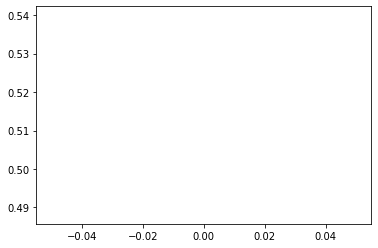

epoch 0 done
epoch 1 start


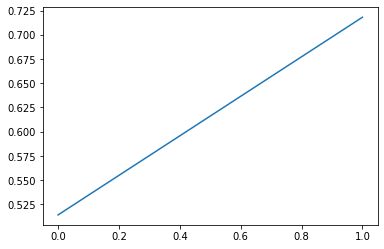

epoch 1 done
epoch 2 start


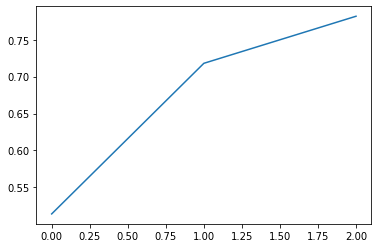

epoch 2 done
epoch 3 start


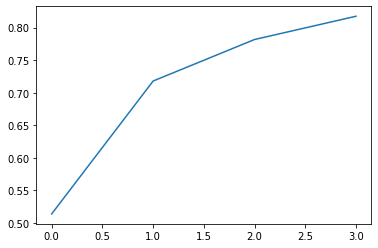

epoch 3 done
epoch 4 start


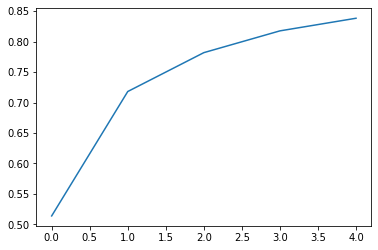

epoch 4 done
epoch 5 start


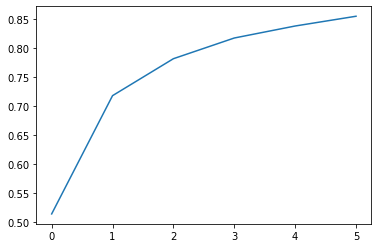

epoch 5 done
epoch 6 start


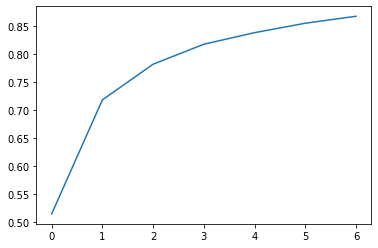

epoch 6 done
epoch 7 start


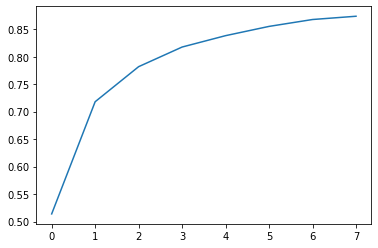

epoch 7 done
epoch 8 start


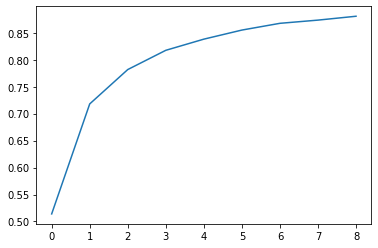

epoch 8 done
epoch 9 start


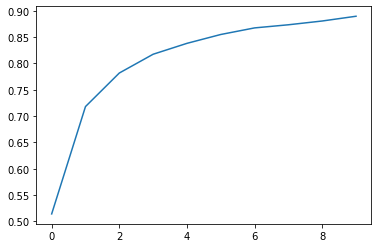

epoch 9 done
epoch 10 start


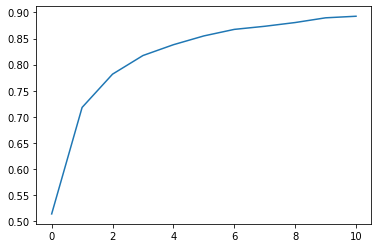

epoch 10 done
epoch 11 start


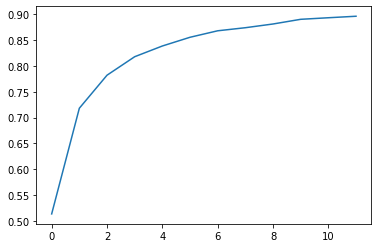

epoch 11 done
epoch 12 start


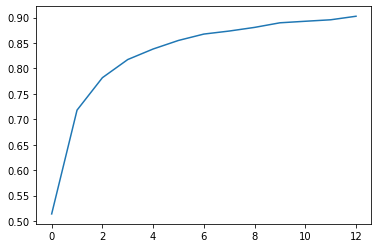

epoch 12 done
epoch 13 start


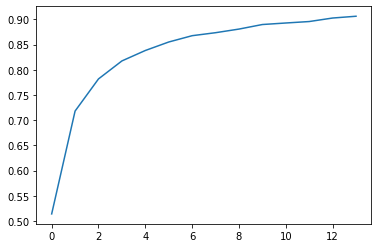

epoch 13 done
epoch 14 start


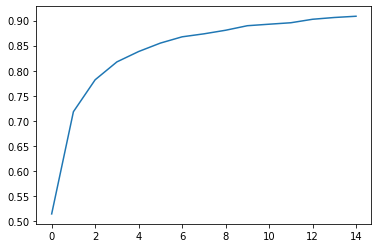

epoch 14 done
epoch 15 start


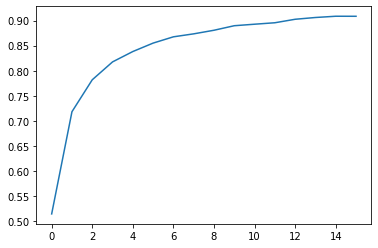

epoch 15 done
epoch 16 start


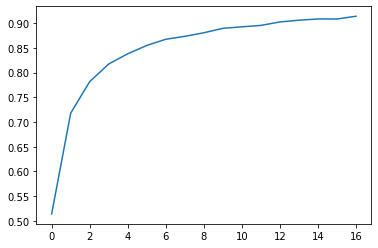

epoch 16 done
epoch 17 start


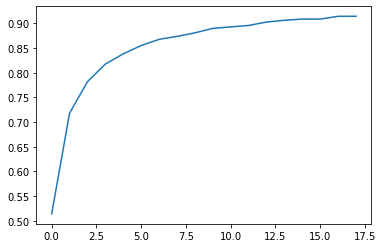

epoch 17 done
epoch 18 start


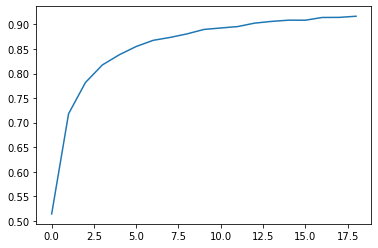

epoch 18 done
epoch 19 start


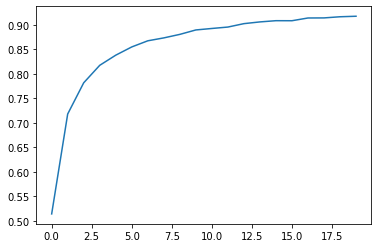

epoch 19 done
epoch 20 start


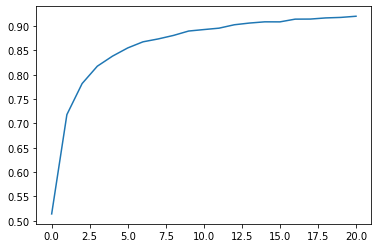

epoch 20 done
epoch 21 start


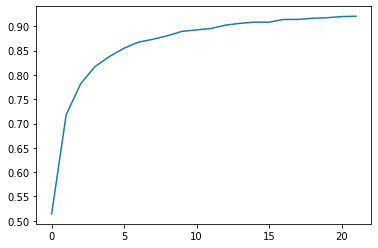

epoch 21 done
epoch 22 start


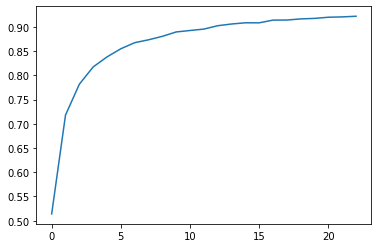

epoch 22 done
epoch 23 start


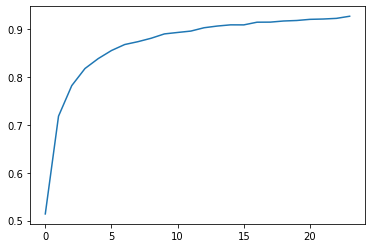

epoch 23 done
epoch 24 start


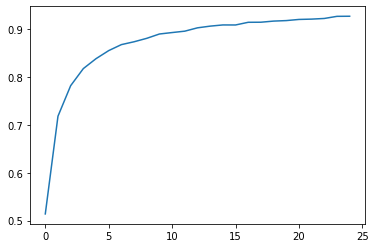

epoch 24 done
epoch 25 start


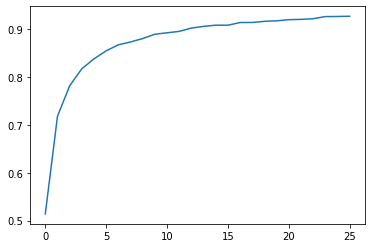

epoch 25 done
epoch 26 start


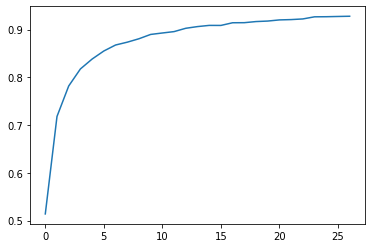

epoch 26 done
epoch 27 start


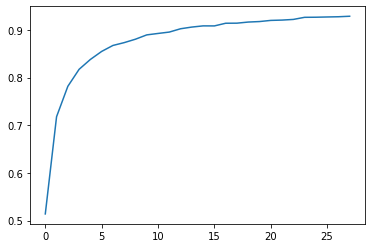

epoch 27 done
epoch 28 start


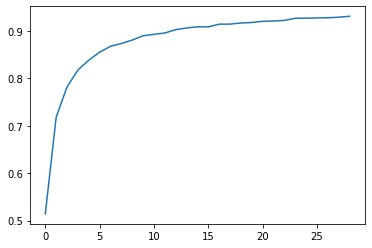

epoch 28 done
epoch 29 start


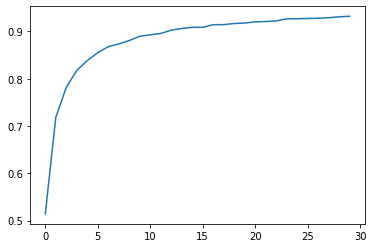

epoch 29 done
epoch 30 start


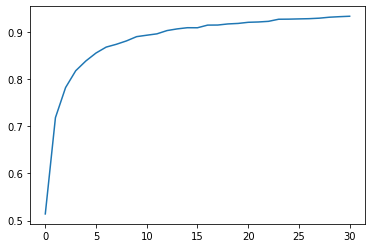

epoch 30 done
epoch 31 start


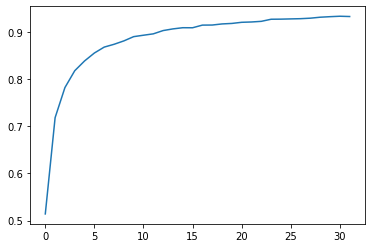

epoch 31 done
epoch 32 start


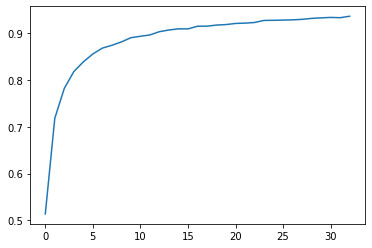

epoch 32 done
epoch 33 start


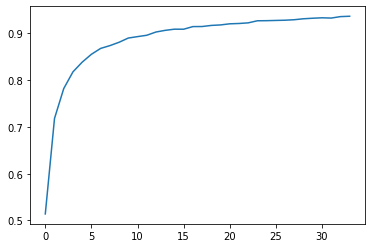

epoch 33 done
epoch 34 start


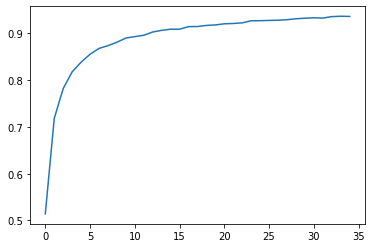

epoch 34 done
epoch 35 start


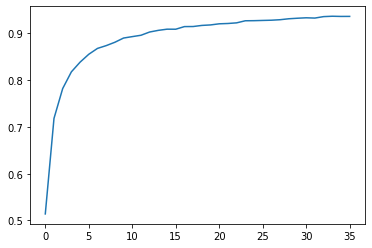

epoch 35 done
epoch 36 start


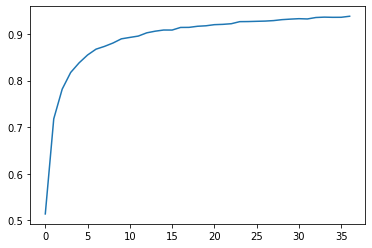

epoch 36 done
epoch 37 start


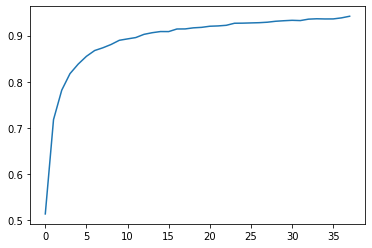

epoch 37 done
epoch 38 start


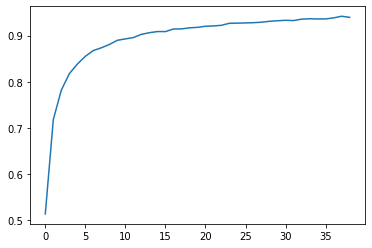

epoch 38 done
epoch 39 start


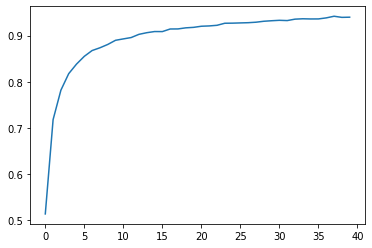

epoch 39 done
epoch 40 start


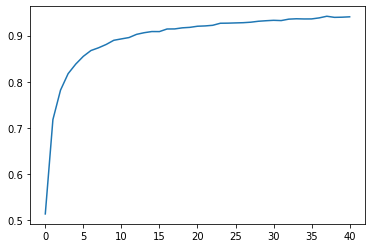

epoch 40 done
epoch 41 start


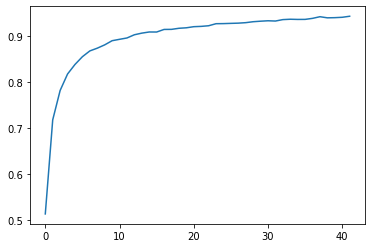

epoch 41 done
epoch 42 start


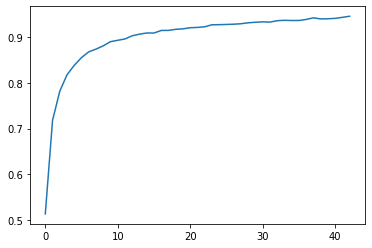

epoch 42 done
epoch 43 start


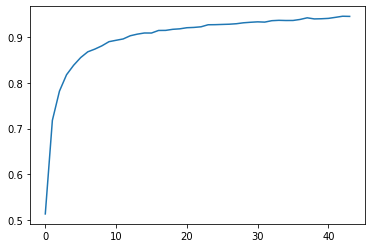

epoch 43 done
epoch 44 start


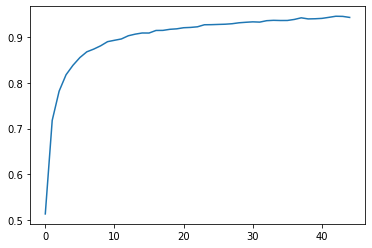

epoch 44 done
epoch 45 start


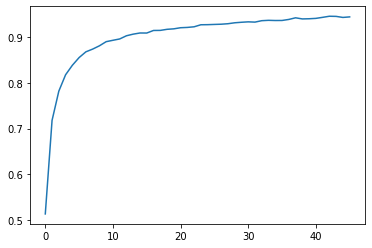

epoch 45 done
epoch 46 start


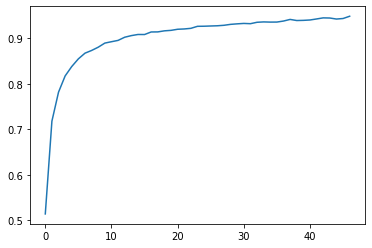

epoch 46 done
epoch 47 start


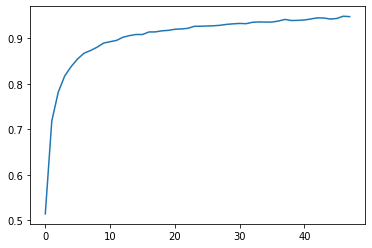

epoch 47 done
epoch 48 start


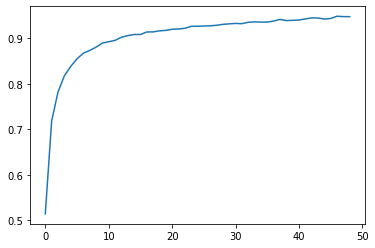

epoch 48 done
epoch 49 start


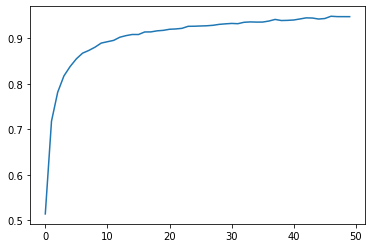

epoch 49 done
epoch 50 start


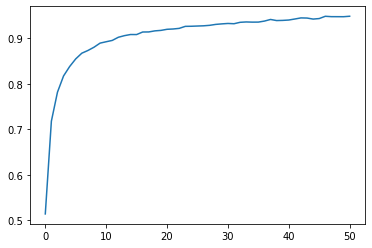

epoch 50 done
epoch 51 start


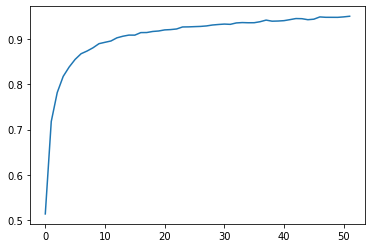

epoch 51 done
epoch 52 start


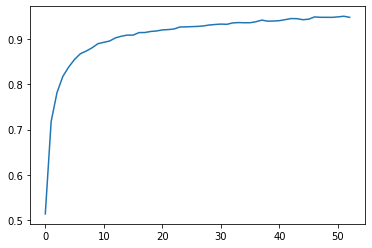

epoch 52 done
epoch 53 start


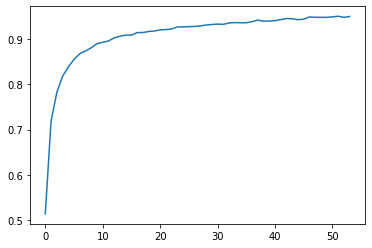

epoch 53 done
epoch 54 start


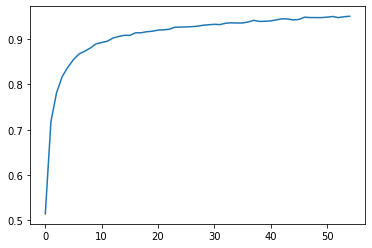

epoch 54 done
epoch 55 start


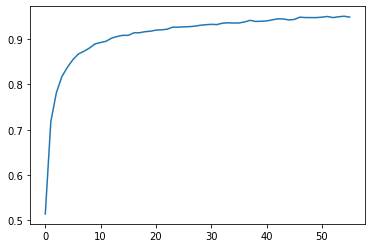

epoch 55 done
epoch 56 start


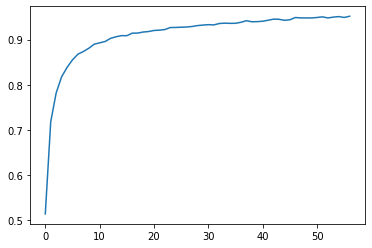

epoch 56 done
epoch 57 start


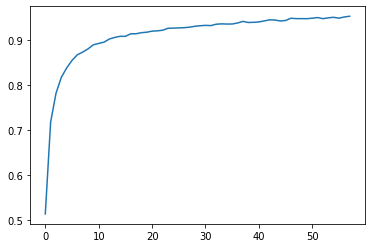

epoch 57 done
epoch 58 start


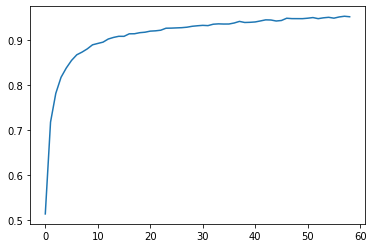

epoch 58 done
epoch 59 start


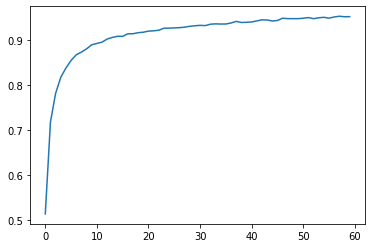

epoch 59 done
epoch 60 start


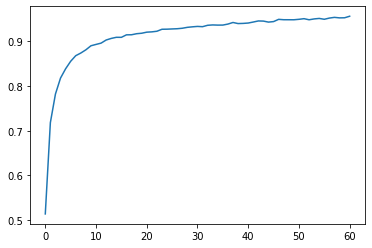

epoch 60 done
epoch 61 start


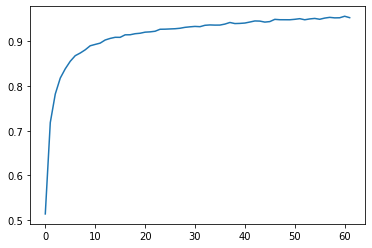

epoch 61 done
epoch 62 start


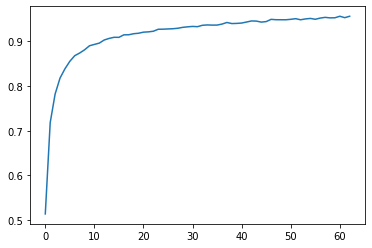

epoch 62 done
epoch 63 start


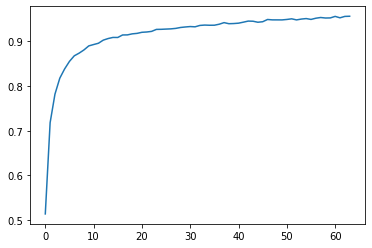

epoch 63 done
epoch 64 start


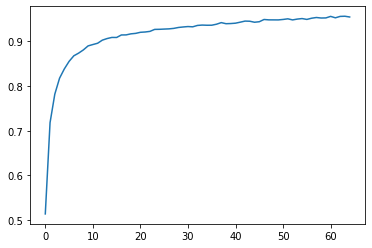

epoch 64 done
epoch 65 start


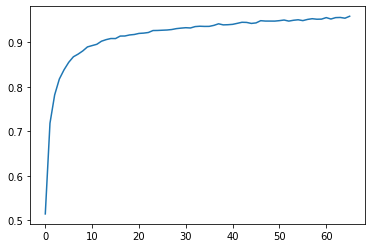

epoch 65 done
epoch 66 start


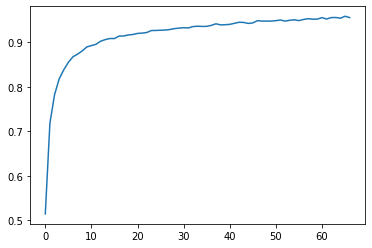

epoch 66 done
epoch 67 start


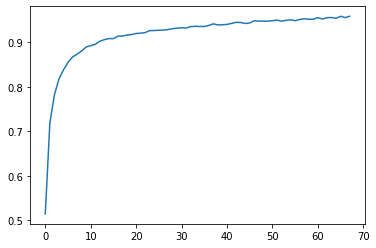

epoch 67 done
epoch 68 start


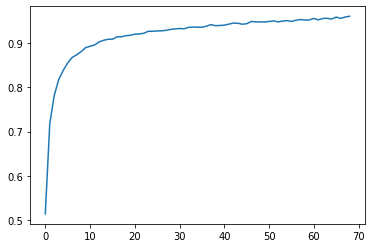

epoch 68 done
epoch 69 start


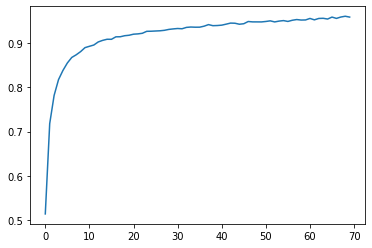

epoch 69 done
epoch 70 start


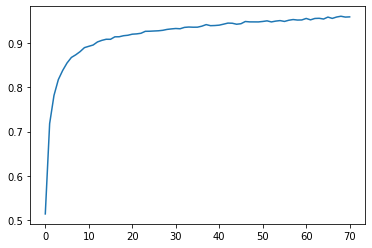

epoch 70 done
epoch 71 start


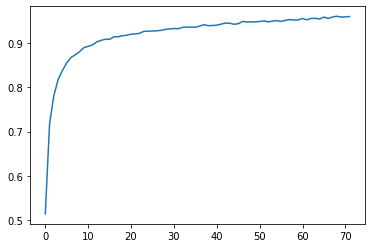

epoch 71 done
epoch 72 start


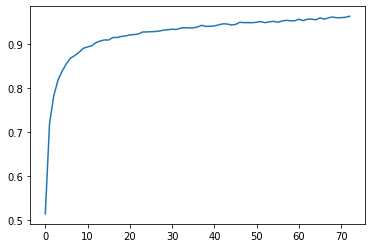

epoch 72 done
epoch 73 start


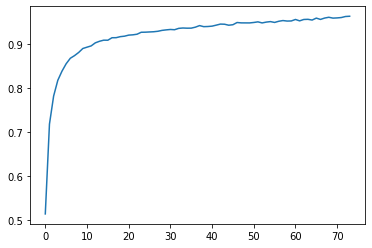

epoch 73 done
epoch 74 start


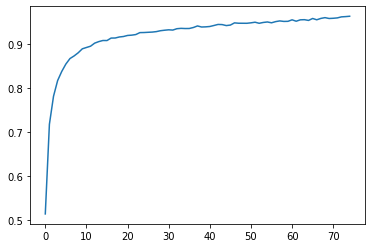

epoch 74 done
epoch 75 start


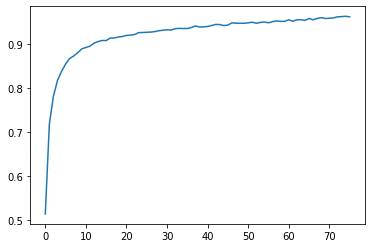

epoch 75 done
epoch 76 start


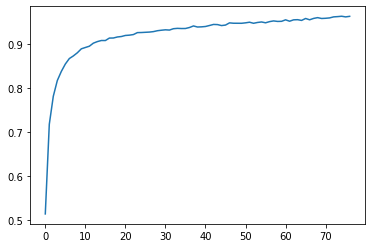

epoch 76 done
epoch 77 start


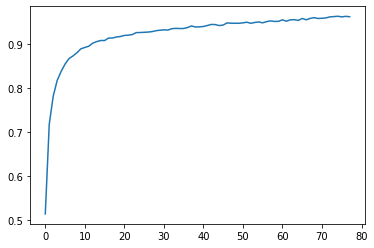

epoch 77 done
epoch 78 start


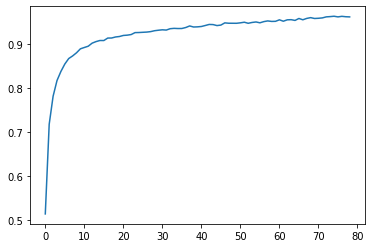

epoch 78 done
epoch 79 start


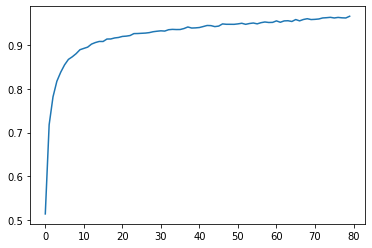

epoch 79 done
epoch 80 start


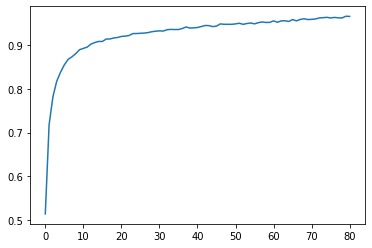

epoch 80 done
epoch 81 start


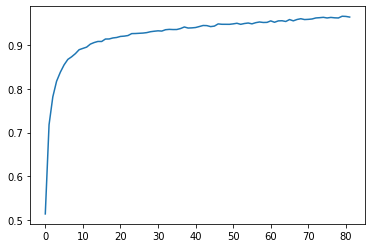

epoch 81 done
epoch 82 start


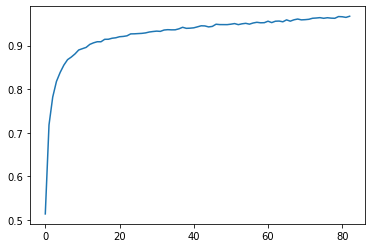

epoch 82 done
epoch 83 start


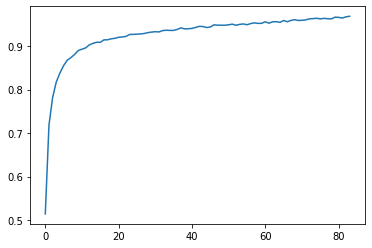

epoch 83 done
epoch 84 start


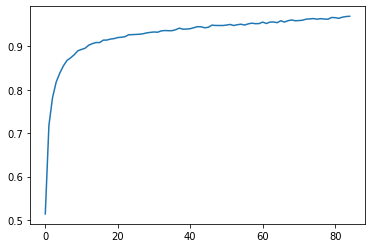

epoch 84 done
epoch 85 start


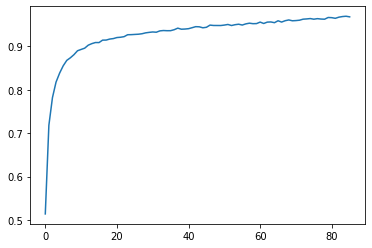

epoch 85 done
epoch 86 start


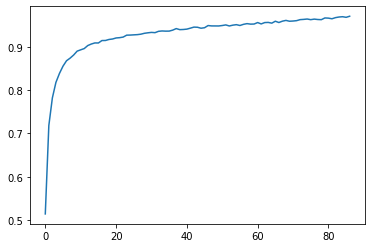

epoch 86 done
epoch 87 start


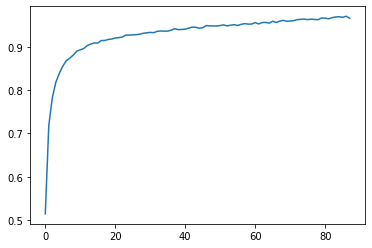

epoch 87 done
epoch 88 start


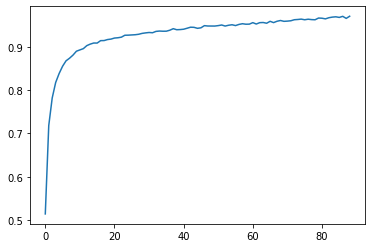

epoch 88 done
epoch 89 start


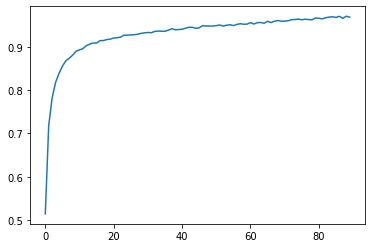

epoch 89 done
epoch 90 start


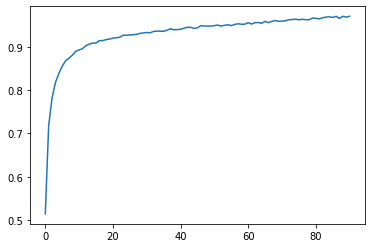

epoch 90 done
epoch 91 start


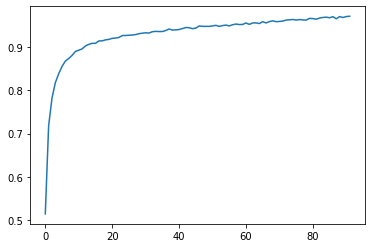

epoch 91 done
epoch 92 start


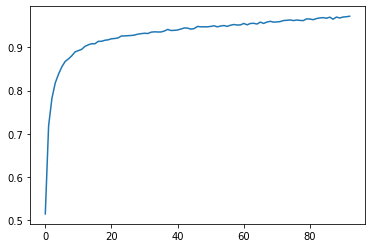

epoch 92 done
epoch 93 start


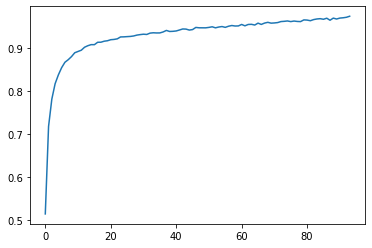

epoch 93 done
epoch 94 start


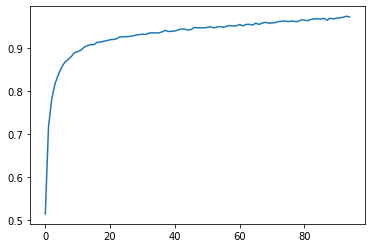

epoch 94 done
epoch 95 start


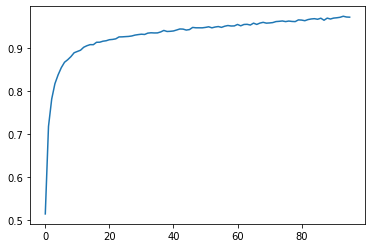

epoch 95 done
epoch 96 start


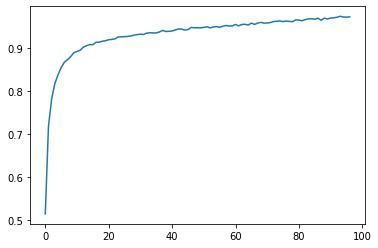

epoch 96 done
epoch 97 start


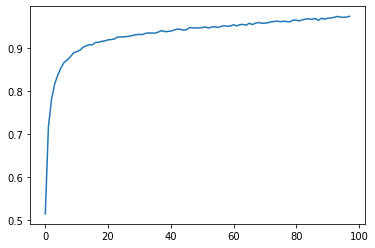

epoch 97 done
epoch 98 start


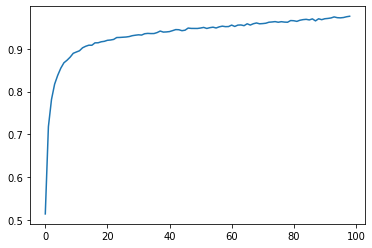

epoch 98 done
epoch 99 start


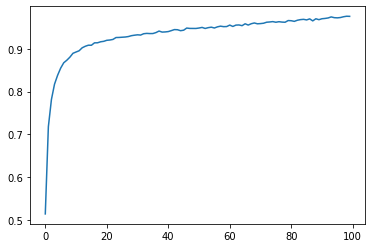

epoch 99 done
epoch 100 start


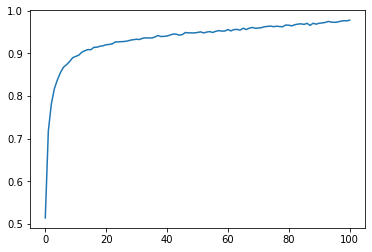

epoch 100 done
epoch 101 start


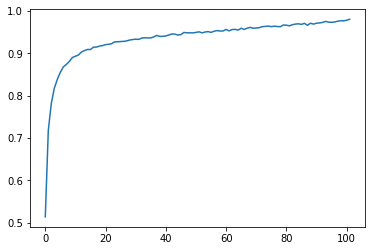

epoch 101 done
epoch 102 start


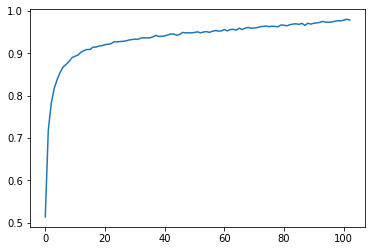

epoch 102 done
epoch 103 start


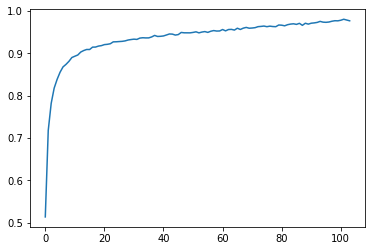

epoch 103 done
epoch 104 start


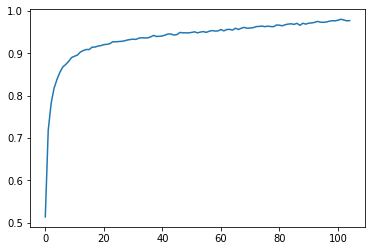

epoch 104 done
epoch 105 start


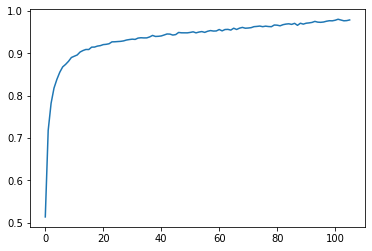

epoch 105 done
epoch 106 start


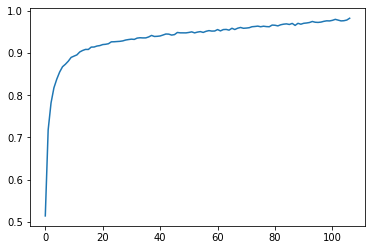

epoch 106 done
epoch 107 start


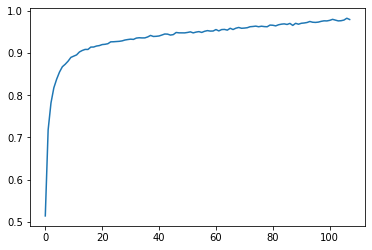

epoch 107 done
epoch 108 start


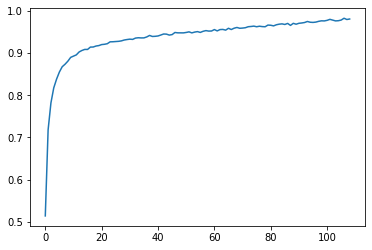

epoch 108 done
epoch 109 start


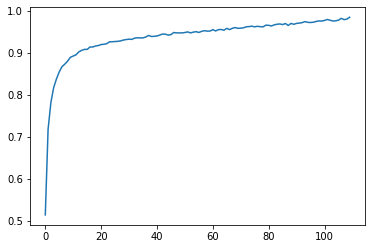

epoch 109 done
epoch 110 start


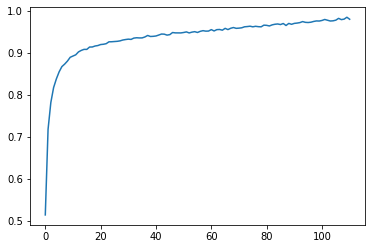

epoch 110 done
epoch 111 start


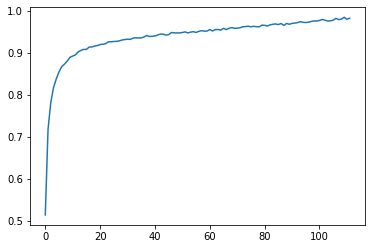

epoch 111 done
epoch 112 start


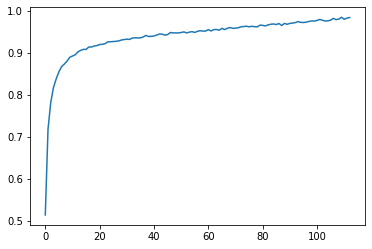

epoch 112 done
epoch 113 start


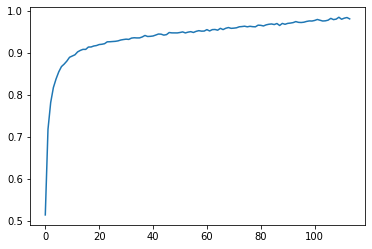

epoch 113 done
epoch 114 start


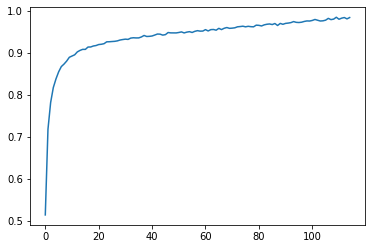

epoch 114 done
epoch 115 start


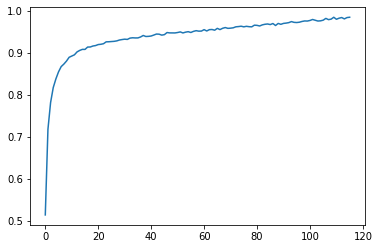

epoch 115 done
epoch 116 start


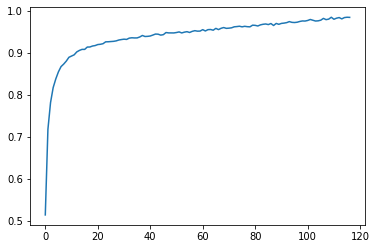

epoch 116 done
epoch 117 start


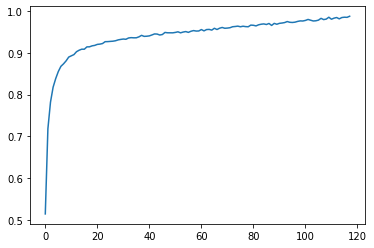

epoch 117 done
epoch 118 start


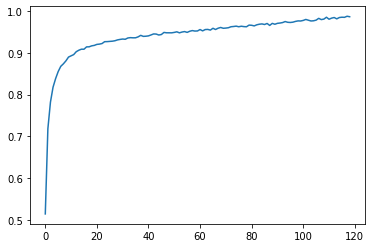

epoch 118 done
epoch 119 start


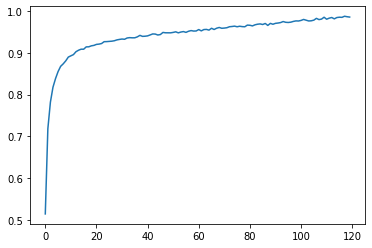

epoch 119 done
epoch 120 start


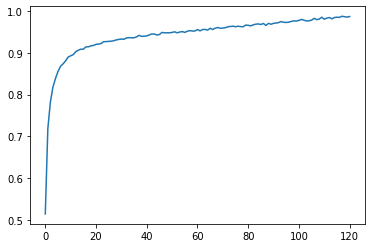

epoch 120 done
epoch 121 start


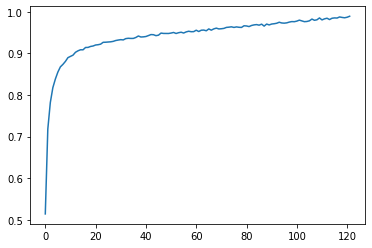

epoch 121 done
epoch 122 start


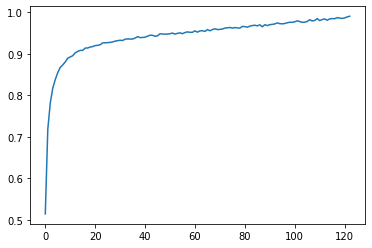

epoch 122 done
epoch 123 start


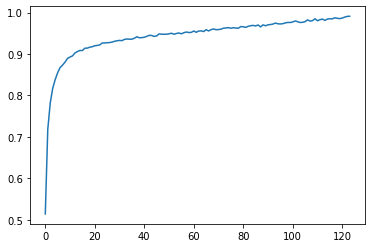

epoch 123 done
epoch 124 start


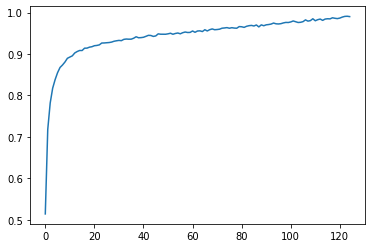

epoch 124 done
epoch 125 start


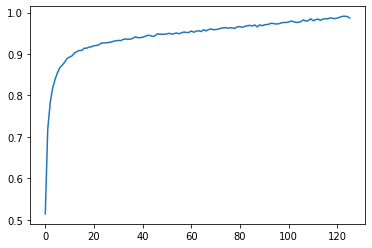

epoch 125 done
epoch 126 start


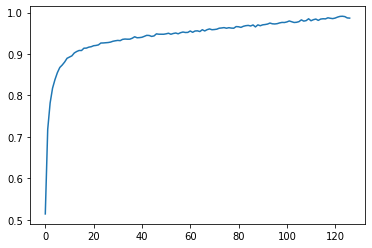

epoch 126 done
epoch 127 start


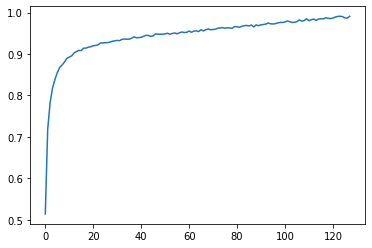

epoch 127 done
epoch 128 start


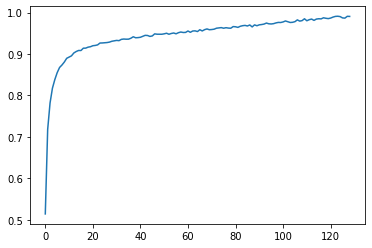

epoch 128 done
epoch 129 start


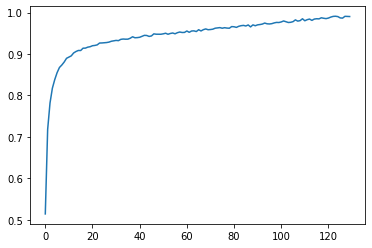

epoch 129 done
epoch 130 start


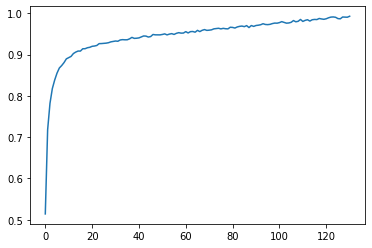

epoch 130 done
epoch 131 start


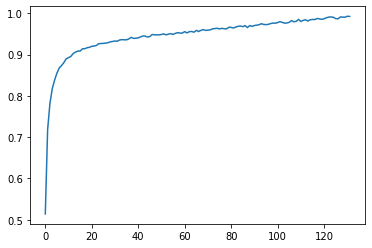

epoch 131 done
epoch 132 start


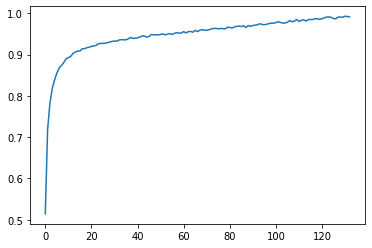

epoch 132 done
epoch 133 start


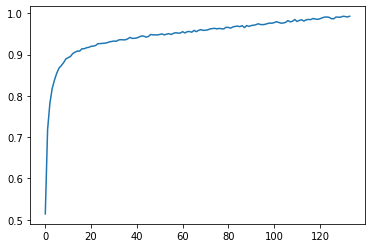

epoch 133 done
epoch 134 start


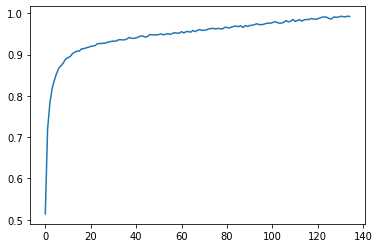

epoch 134 done
epoch 135 start


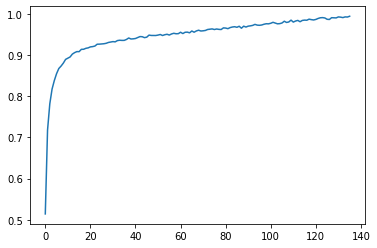

epoch 135 done
epoch 136 start


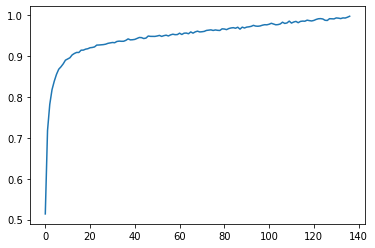

epoch 136 done
epoch 137 start


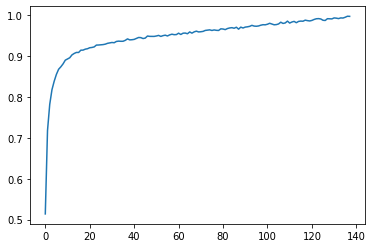

epoch 137 done
epoch 138 start


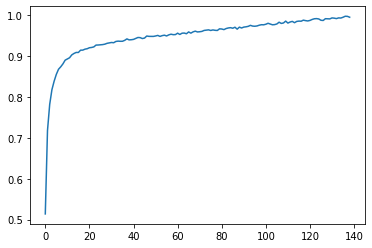

epoch 138 done
epoch 139 start


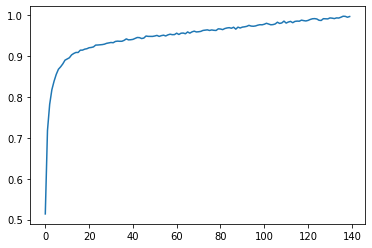

epoch 139 done
epoch 140 start


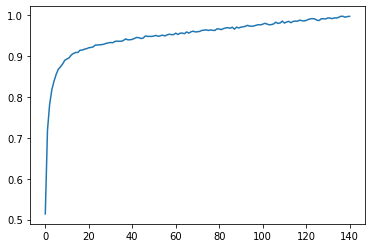

epoch 140 done
epoch 141 start


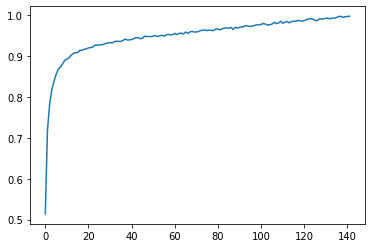

epoch 141 done
epoch 142 start


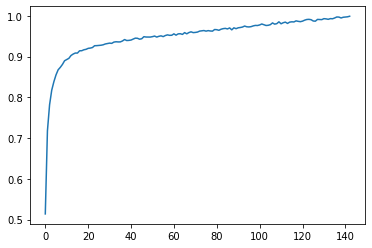

epoch 142 done
epoch 143 start


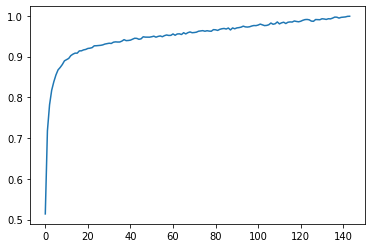

epoch 143 done
epoch 144 start


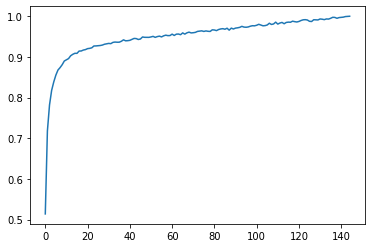

epoch 144 done
epoch 145 start


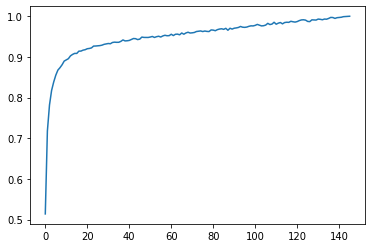

epoch 145 done
epoch 146 start


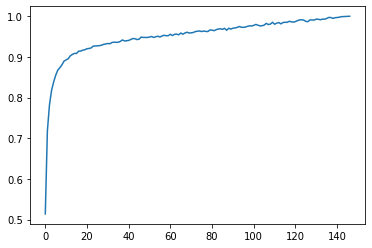

epoch 146 done
epoch 147 start


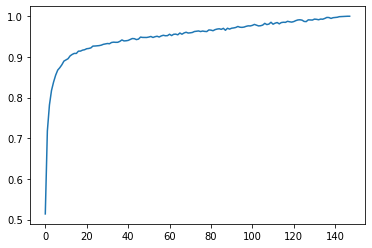

epoch 147 done
epoch 148 start


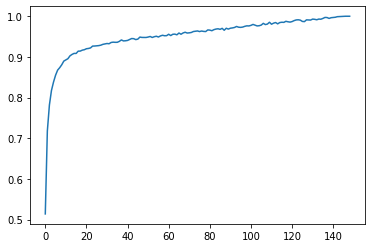

epoch 148 done
epoch 149 start


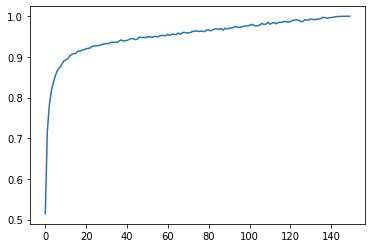

epoch 149 done
epoch 150 start


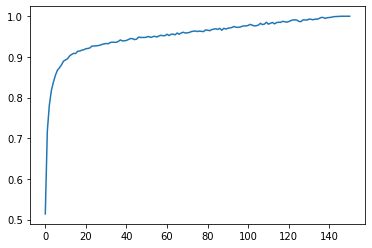

epoch 150 done
epoch 151 start


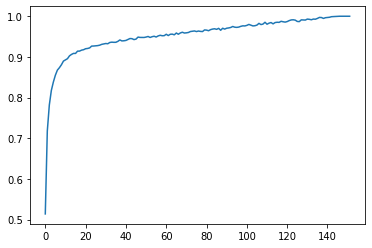

epoch 151 done
epoch 152 start


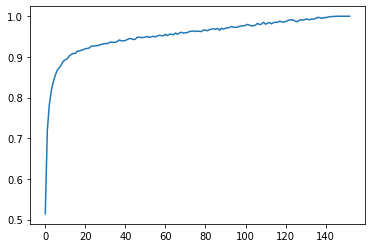

epoch 152 done
epoch 153 start


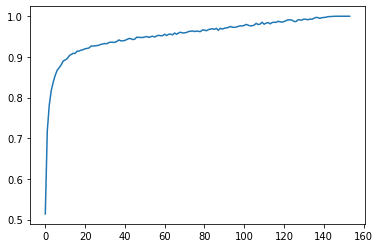

epoch 153 done
epoch 154 start


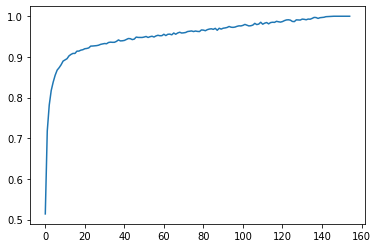

epoch 154 done
epoch 155 start


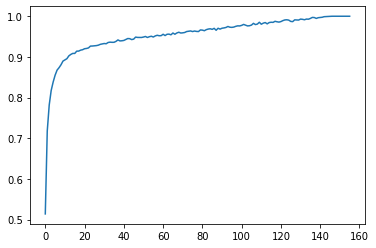

epoch 155 done
epoch 156 start


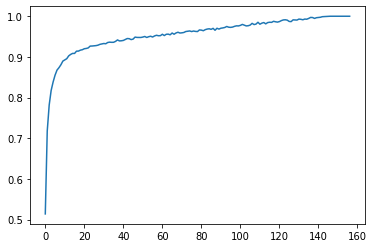

epoch 156 done
epoch 157 start


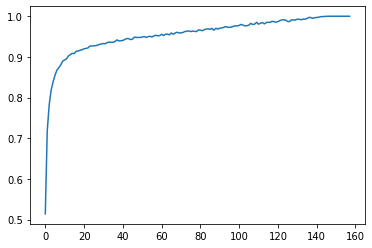

epoch 157 done
epoch 158 start


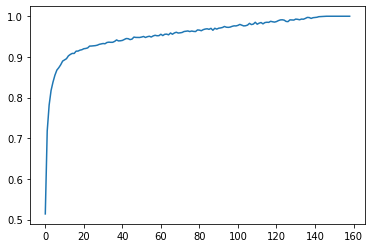

epoch 158 done
epoch 159 start


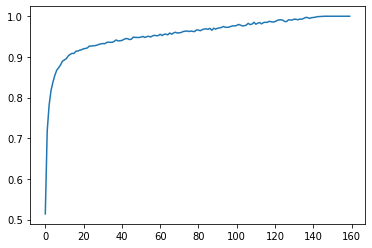

epoch 159 done
epoch 160 start


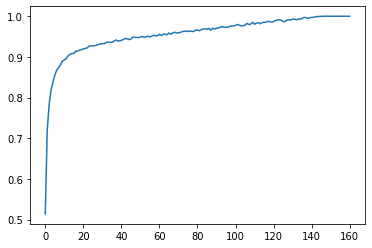

epoch 160 done
epoch 161 start


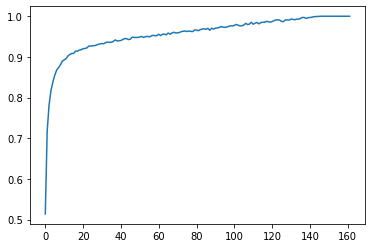

epoch 161 done
epoch 162 start


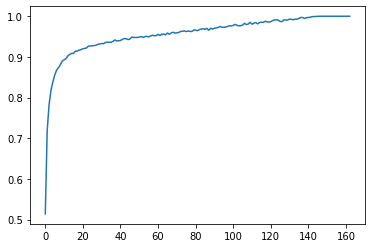

epoch 162 done
epoch 163 start


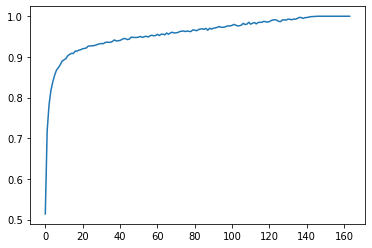

epoch 163 done
epoch 164 start


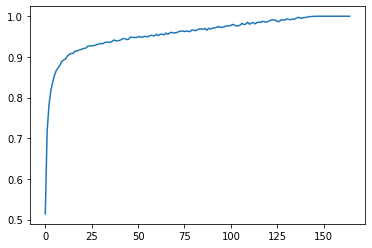

epoch 164 done
epoch 165 start


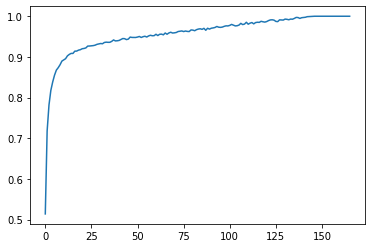

epoch 165 done
epoch 166 start


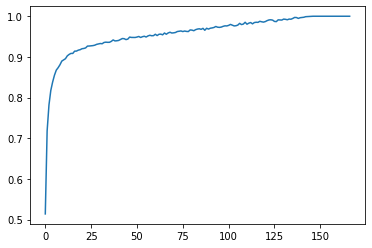

epoch 166 done
epoch 167 start


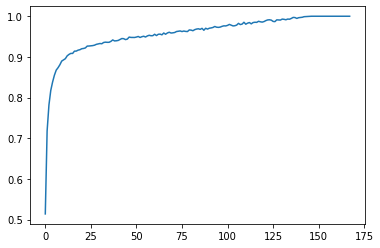

epoch 167 done
epoch 168 start


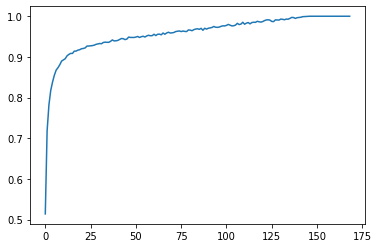

epoch 168 done
epoch 169 start


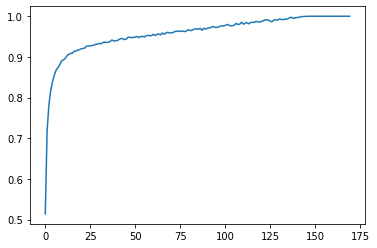

epoch 169 done
epoch 170 start


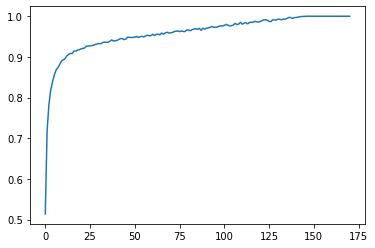

epoch 170 done
epoch 171 start


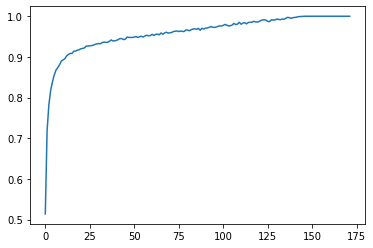

epoch 171 done
epoch 172 start


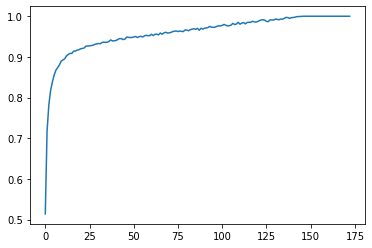

epoch 172 done
epoch 173 start


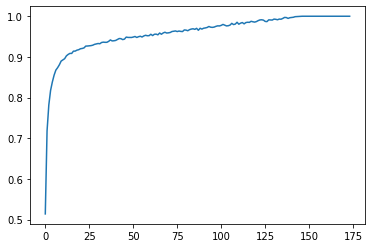

epoch 173 done
epoch 174 start


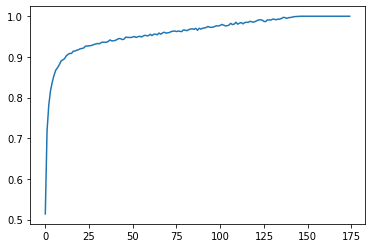

epoch 174 done
epoch 175 start


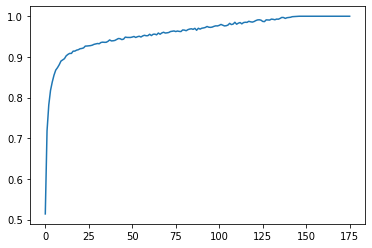

epoch 175 done
epoch 176 start


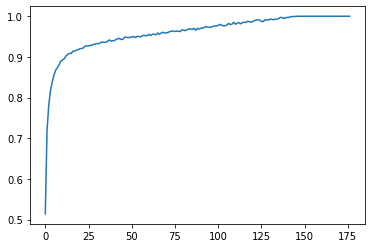

epoch 176 done
epoch 177 start


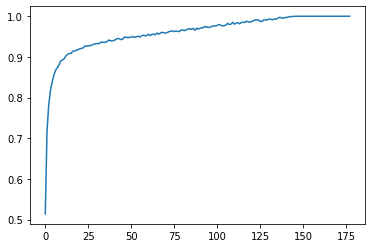

epoch 177 done
epoch 178 start


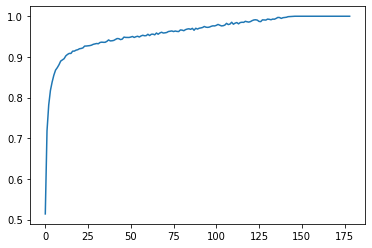

epoch 178 done
epoch 179 start


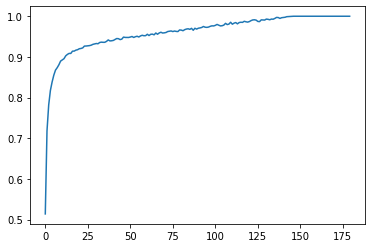

epoch 179 done
epoch 180 start


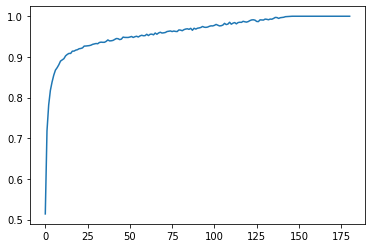

epoch 180 done
epoch 181 start


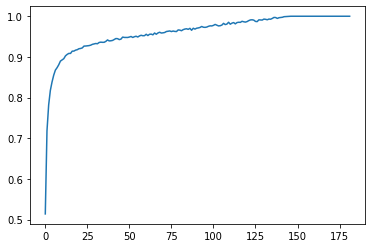

epoch 181 done
epoch 182 start


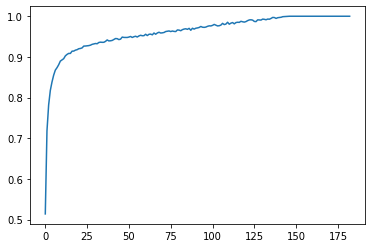

epoch 182 done
epoch 183 start


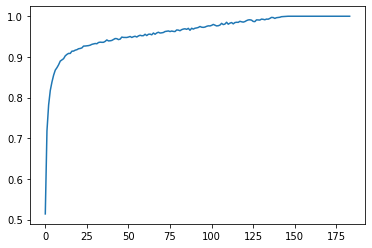

epoch 183 done
epoch 184 start


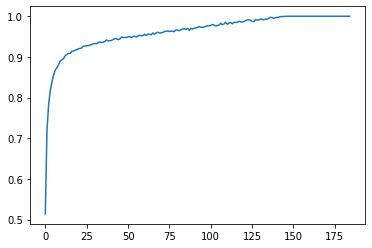

epoch 184 done
epoch 185 start


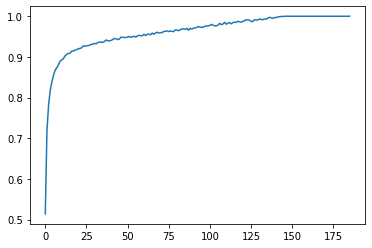

epoch 185 done
epoch 186 start


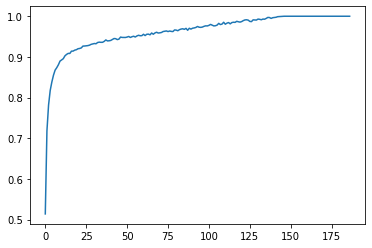

epoch 186 done
epoch 187 start


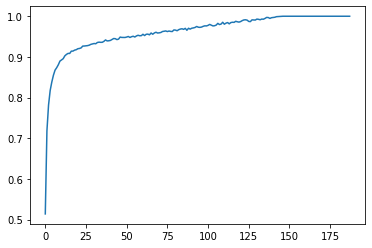

epoch 187 done
epoch 188 start


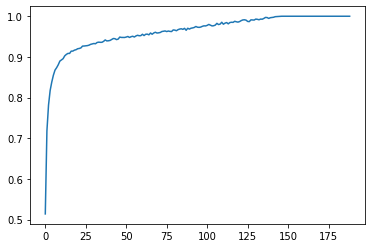

epoch 188 done
epoch 189 start


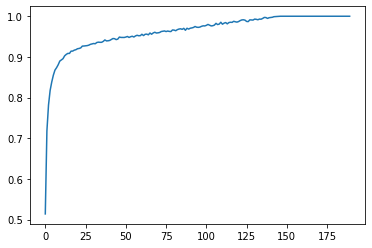

epoch 189 done
epoch 190 start


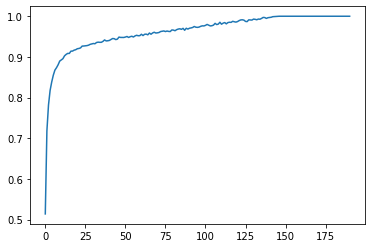

epoch 190 done
epoch 191 start


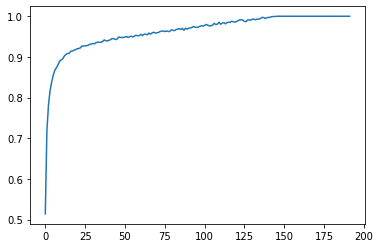

epoch 191 done
epoch 192 start


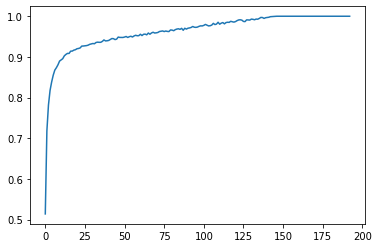

epoch 192 done
epoch 193 start


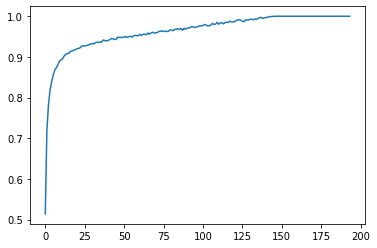

epoch 193 done
epoch 194 start


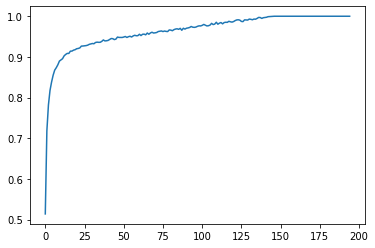

epoch 194 done
epoch 195 start


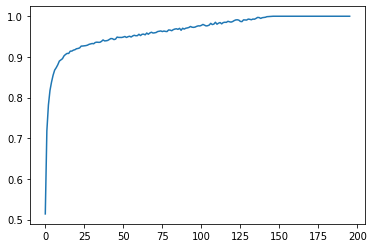

epoch 195 done
epoch 196 start


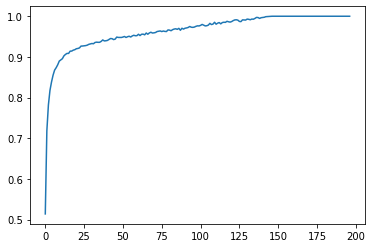

epoch 196 done
epoch 197 start


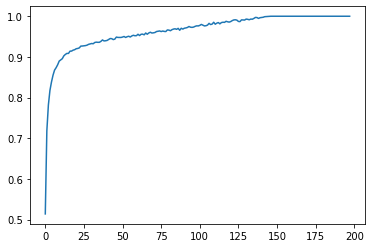

epoch 197 done
epoch 198 start


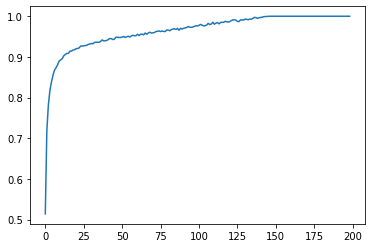

epoch 198 done
epoch 199 start


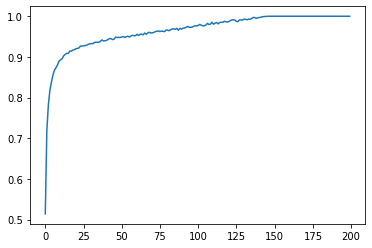

epoch 199 done


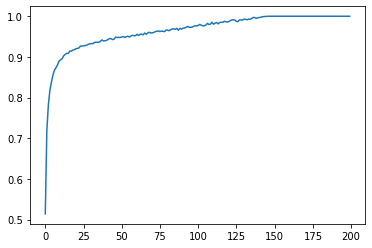

Final Judge:
Accuracy of the network on the 10000 test images: 85.69 %


In [7]:
def Score(Arch, final= False):
    return get_metric(Arch, final)
Arch = [6,7,1,5,1,7]
print(Arch)
final_score = Score(Arch, final= True)